<a href="https://colab.research.google.com/github/ravi-gopalan/predicting_pneumonia/blob/master/chest_xray_predictions_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!find -type d -name capstone -exec rm -rf {} \;

find: ‘./capstone’: No such file or directory


In [0]:
rm chest-xray-pneumonia.zip

In [23]:
cd /content/chest_xray

/content/chest_xray


In [24]:
!ls -la

total 20
drwxr-xr-x 5 root root 4096 May 22 12:53 .
drwxr-xr-x 1 root root 4096 May 22 12:53 ..
drwxr-xr-x 4 root root 4096 May 22 12:53 test
drwxr-xr-x 4 root root 4096 May 22 12:53 train
drwxr-xr-x 4 root root 4096 May 22 12:53 val


Create 2 folders within the /content folder '.kaggle' and 'capstone'

In [3]:
!cd /content
!mkdir .kaggle
!mkdir capstone
!ls -la

total 24
drwxr-xr-x 1 root root 4096 May 22 12:30 .
drwxr-xr-x 1 root root 4096 May 22 12:27 ..
drwxr-xr-x 2 root root 4096 May 22 12:30 capstone
drwxr-xr-x 1 root root 4096 May 20 16:07 .config
drwxr-xr-x 2 root root 4096 May 22 12:30 .kaggle
drwxr-xr-x 1 root root 4096 May 15 16:23 sample_data


Create the kaggle.json file using the API token. This will help download the data directly from Kaggle dataset

In [0]:
import json
token = {"username":"ravijee","key":"e4042f800aaee606f244555554f6fd8e"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

Create a .kaggle folder within the root directory and copy the contents of the kaggle.json.
Change the permissions of the file

In [0]:
!cd /root
!mkdir .kaggle
    
!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

Download Data from Kaggle website through API. Data gets downloaded as chest-xray-pneumonia.zip

---
Unzip the file. This then creates a folder called chest_xray.zip  

---

Unzip the chest_xray.zip file, which then creates a directory called chest_xray and subdirectories containing train, val and test subdirectories as well as a __MACOSX folder

---

Remove the __MACOSX folder


In [19]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content
!unzip /content/chest-xray-pneumonia.zip
!cd /content

!unzip /content/chest_xray.zip
!ls -la

100% 1.15G/1.15G [00:13<00:00, 93.6MB/s]
100% 1.15G/1.15G [00:14<00:00, 88.2MB/s]
Archive:  /content/chest-xray-pneumonia.zip
  inflating: chest_xray.zip          
Archive:  /content/chest_xray.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
   creating: __MACOSX/chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: __MAC

In [0]:
!rm /content/chest-xray-pneumonia.zip
!rm /content/chest_xray.zip
!cd /content/chest_xray
!rm -r __MACOSX

Pre-processing

---

The data file has multiple directories anf files names '.DS_Store'.
Remove all files and directories named '.DS_Store' as they will cause issues in our processing

In [0]:
!cd /content/chest_xray
!find -type d -name .DS_Store -exec ls -a {} \;
!find -type d -name .DS_Store -exec rm -rf {} \;
!find -name .DS_Store -exec rm -rf {} \;

!cd /content/chest_xray
!find -type d -name .DS_Store -exec ls -a {} \;
!find -name .DS_Store -exec ls -a {} \;


In [22]:
!cd /content/chest_xray
!ls -la

total 28
drwxr-xr-x 1 root root 4096 May 22 12:53 .
drwxr-xr-x 1 root root 4096 May 22 12:27 ..
drwxr-xr-x 2 root root 4096 May 22 12:30 capstone
drwxr-xr-x 5 root root 4096 May 22 12:53 chest_xray
drwxr-xr-x 1 root root 4096 May 20 16:07 .config
drwxr-xr-x 2 root root 4096 May 22 12:30 .kaggle
drwxr-xr-x 1 root root 4096 May 15 16:23 sample_data


Import the libraries that will be required
os, pathlib for file operations
glob to get the image files
PIL for image manipulations
numpy, pandas for array operations
matplotlib, seaborn for graphical visualizations

In [25]:
import os
from pathlib import Path
import glob
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.datasets import load_files
from keras.utils import np_utils

from keras.preprocessing import image
from imblearn.under_sampling import RandomUnderSampler

from tqdm import tqdm

from PIL import ImageFile

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, History
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
# Ensure results are reproducible
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

seed=42

# Set the numpy seed
np.random.seed(seed)

Create variables to get the image files from the path 

In [27]:
# data path
data_dir = Path('/content/chest_xray')

# path to directory containing train set
train_dir = data_dir / 'train'

# path to directory containing validation set
val_dir = data_dir / 'val'

# path to the directory containing test set
test_dir = data_dir / 'test'

type(data_dir)

pathlib.PosixPath

Create a helper function 'load_dataset(path)' that takes in a path argument,loads the files and creates a tuple of the filenames showing the filenames and the target( 1 for Normal and 0 for Pneumonia)

In [0]:

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    xray_files = np.array(data['filenames'])
    xray_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return xray_files, xray_targets

  
  
# load train, test, and validation datasets
train_files, train_targets = load_dataset(train_dir)
valid_files, valid_targets = load_dataset(val_dir)
test_files, test_targets = load_dataset(test_dir)


In [32]:
print('There are %s total x_ray images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training x_ray images.' % len(train_files))
print('There are %d validation x_ray images.' % len(valid_files))
print('There are %d test x_ray images.'% len(test_files))

print('Total cases in the train set: {}'.format(train_targets.shape[0]))
print('Normal cases in the train set: {}'.format(np.count_nonzero(train_targets,axis=0)[0]))
print('% of Normal cases in the train set: {:.1%}'.format(np.count_nonzero(train_targets,axis=0)[0]/train_targets.shape[0]))

print('Total cases in the validation set: {}'.format(valid_targets.shape[0]))
print('Normal cases in the validation set: {}'.format(np.count_nonzero(valid_targets,axis=0)[0]))
print('% of Normal cases in the validation set: {:.1%}'.format(np.count_nonzero(valid_targets,axis=0)[0]/valid_targets.shape[0]))

print('Total cases in the test set: {}'.format(test_targets.shape[0]))
print('Normal cases in the test set: {}'.format(np.count_nonzero(test_targets,axis=0)[0]))
print('% of Normal cases in the test set: {:.1%}'.format(np.count_nonzero(test_targets,axis=0)[0]/test_targets.shape[0]))

There are 5856 total x_ray images.

There are 5216 training x_ray images.
There are 16 validation x_ray images.
There are 624 test x_ray images.
Total cases in the train set: 5216
Normal cases in the train set: 1341
% of Normal cases in the train set: 25.7%
Total cases in the validation set: 16
Normal cases in the validation set: 8
% of Normal cases in the validation set: 50.0%
Total cases in the test set: 624
Normal cases in the test set: 234
% of Normal cases in the test set: 37.5%


Insert a graphic representation of the distribution of the input data

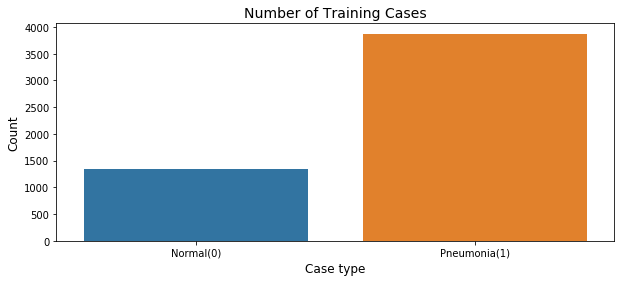

In [33]:
# Get the counts for each class
df_train = pd.DataFrame({'Pneumonia':train_targets[:,1]})
training_count = df_train['Pneumonia'].value_counts()
# Plot the results 
plt.figure(figsize=(10,4))
sns.barplot(x=training_count.index, y= training_count.values)
plt.title('Number of Training Cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(training_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

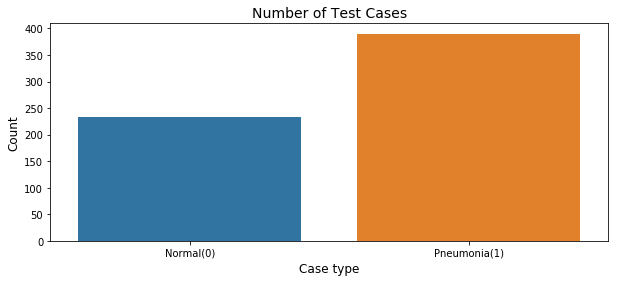

In [34]:
# Get the counts for each class
df_test = pd.DataFrame({'Pneumonia':test_targets[:,1]})
test_count = df_test['Pneumonia'].value_counts()
# Plot the results 
plt.figure(figsize=(10,4))
sns.barplot(x=test_count.index, y= test_count.values)
plt.title('Number of Test Cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(test_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

The training data set is unbalanced with normal cases at ~25% and ~75% of pneumonia cases that may bias our learning algorithm and hence will need to be balanced

In [0]:
rus = RandomUnderSampler(ratio='majority',random_state=42)
train_files_rebalanced, train_targets_rebalanced = rus.fit_sample(train_files.reshape(-1,1), train_targets)

In [36]:
print('Total cases in the resampled train set: {}'.format(train_targets_rebalanced.shape[0]))
print('Normal cases in the resampled train set: {}'.format(np.count_nonzero(train_targets_rebalanced,axis=0)[0]))
print('% of Normal cases in the resampled train set: {:.1%}'.format(np.count_nonzero(train_targets_rebalanced,axis=0)[0]/train_targets_rebalanced.shape[0]))

Total cases in the resampled train set: 2682
Normal cases in the resampled train set: 1341
% of Normal cases in the resampled train set: 50.0%


Create a visual representation of some random x-rays showing normal and pneumonia afflicted lungs to see how they are different

Tensor for the CNN

In [0]:


def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(256, 256))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)
  
  


Load all the images and create the tensor for processing

In [38]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255
train_tensors_rebalanced = paths_to_tensor(np.squeeze(train_files_rebalanced)).astype('float32')/255

100%|██████████| 2682/2682 [00:49<00:00, 44.04it/s]


Create the Keras CNN model with 4 convolutional layers (each with relu activation, followed by max pooling, dropout and Batch Normalization) and finally a Global Average Pooling followed by a Dense layer

In [0]:
def create_CNN_model(filters = [16, 32, 64, 128, 256], kernel_size = 2, padding = 'valid', \
                     activation = 'relu', input_shape = (256, 256, 3), dropout_rate = 0.2, \
                     pool_size=2, final_activation = 'softmax'):
  model = Sequential()

  model.add(Conv2D(filters=filters[0], kernel_size=kernel_size, padding=padding, activation=activation,input_shape=input_shape))
  model.add(MaxPooling2D(pool_size))
  model.add(Dropout(dropout_rate))
  model.add(BatchNormalization())
            
  model.add(Conv2D(filters=filters[1], kernel_size=kernel_size, padding=padding, activation=activation))
  model.add(MaxPooling2D(pool_size))
  model.add(Dropout(dropout_rate))
  model.add(BatchNormalization())
            
  model.add(Conv2D(filters=filters[2], kernel_size=kernel_size, padding=padding, activation=activation))
  model.add(MaxPooling2D(pool_size))
  model.add(Dropout(dropout_rate))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=filters[3], kernel_size=kernel_size, padding=padding, activation=activation))
  model.add(MaxPooling2D(pool_size))
  model.add(Dropout(dropout_rate))
  model.add(BatchNormalization())
            
  model.add(Conv2D(filters=filters[4], kernel_size=kernel_size, padding=padding, activation=activation))
  model.add(MaxPooling2D(pool_size))
  model.add(Dropout(dropout_rate))
  model.add(BatchNormalization())
             
  model.add(GlobalAveragePooling2D())


  model.add(Dense(2, activation=final_activation))
            
  return model

In [40]:
cnn_model1 = create_CNN_model(filters = [32, 64, 128, 128, 256], kernel_size = 2, padding = 'valid', \
                     activation = 'relu', input_shape = (256, 256, 3), dropout_rate = 0.1, \
                     pool_size=2, final_activation = 'softmax')

cnn_model1.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 255, 255, 32)      416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 127, 127, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 64)      8256      
_________________________________________________________________
max_pooling2d_2 (MaxP

In [41]:
cnn_model2 = create_CNN_model(filters = [32, 64, 128, 128, 256], kernel_size = 2, padding = 'valid', \
                     activation = 'relu', input_shape = (256, 256, 3), dropout_rate = 0.2, \
                     pool_size=2, final_activation = 'softmax')

cnn_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 255, 255, 32)      416       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 127, 127, 32)      128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 126, 126, 64)      8256      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 63, 63, 64)        0         
__________

In [42]:
cnn_model3 = create_CNN_model(filters = [32, 64, 128, 128, 256], kernel_size = 2, padding = 'valid', \
                     activation = 'relu', input_shape = (256, 256, 3), dropout_rate = 0.25, \
                     pool_size=2, final_activation = 'softmax')

cnn_model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 255, 255, 32)      416       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 127, 127, 32)      0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 127, 127, 32)      128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 126, 126, 64)      8256      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 63, 63, 64)        0         
__________

In [43]:
cnn_model4 = create_CNN_model(filters = [32, 64, 128, 128, 256], kernel_size = 2, padding = 'valid', \
                     activation = 'relu', input_shape = (256, 256, 3), dropout_rate = 0.5, \
                     pool_size=2, final_activation = 'softmax')

cnn_model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 255, 255, 32)      416       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 127, 127, 32)      0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 127, 127, 32)      128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 126, 126, 64)      8256      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 63, 63, 64)        0         
__________

Compile the model and then run

In [44]:
!cd /content/chest_xray
!mkdir saved_models
!ls -la

total 24
drwxr-xr-x 6 root root 4096 May 22 13:01 .
drwxr-xr-x 1 root root 4096 May 22 12:53 ..
drwxr-xr-x 2 root root 4096 May 22 13:01 saved_models
drwxr-xr-x 4 root root 4096 May 22 12:53 test
drwxr-xr-x 4 root root 4096 May 22 12:53 train
drwxr-xr-x 4 root root 4096 May 22 12:53 val


In [0]:
cnn_model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model4.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
batch_size = 64
epochs = 50

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, mode='min')
checkpoint_unbal_cnn1 = ModelCheckpoint(filepath='saved_models/best_cnn1_unbal.hdf5', \
                                              monitor='val_loss', mode='min', verbose=1, save_best_only=True)

checkpoint_unbal_cnn2 = ModelCheckpoint(filepath='saved_models/best_cnn2_unbal.hdf5', \
                                              monitor='val_loss', mode='min', verbose=1, save_best_only=True)

checkpoint_unbal_cnn3 = ModelCheckpoint(filepath='saved_models/best_cnn3_unbal.hdf5', \
                                              monitor='val_loss', mode='min', verbose=1, save_best_only=True)

checkpoint_unbal_cnn4 = ModelCheckpoint(filepath='saved_models/best_cnn4_unbal.hdf5', \
                                              monitor='val_loss', mode='min', verbose=1, save_best_only=True)


datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=180,
    horizontal_flip=True,vertical_flip = True)

train_unbal_cnn1 = cnn_model1.fit_generator(datagen.flow(train_tensors, train_targets,batch_size=batch_size),\
                               steps_per_epoch=len(train_tensors)/batch_size, epochs=epochs,\
                               validation_data=(valid_tensors, valid_targets), verbose=1, \
                               callbacks=[early_stopping_monitor, checkpoint_unbal_cnn1])

train_unbal_cnn2 = cnn_model2.fit_generator(datagen.flow(train_tensors, train_targets,batch_size=batch_size),\
                               steps_per_epoch=len(train_tensors)/batch_size, epochs=epochs,\
                               validation_data=(valid_tensors, valid_targets), verbose=1, \
                               callbacks=[early_stopping_monitor, checkpoint_unbal_cnn2])

train_unbal_cnn3 = cnn_model3.fit_generator(datagen.flow(train_tensors, train_targets,batch_size=batch_size),\
                               steps_per_epoch=len(train_tensors)/batch_size, epochs=epochs,\
                               validation_data=(valid_tensors, valid_targets), verbose=1, \
                               callbacks=[early_stopping_monitor, checkpoint_unbal_cnn3])

train_unbal_cnn4 = cnn_model4.fit_generator(datagen.flow(train_tensors, train_targets,batch_size=batch_size),\
                               steps_per_epoch=len(train_tensors)/batch_size, epochs=epochs,\
                               validation_data=(valid_tensors, valid_targets), verbose=1, \
                               callbacks=[early_stopping_monitor, checkpoint_unbal_cnn4])

Epoch 1/50
82/81 [==============================] - 63s 774ms/step - loss: 0.3125 - acc: 0.8744 - val_loss: 5.2734 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 5.27342, saving model to saved_models/best_cnn1_unbal.hdf5
Epoch 2/50
82/81 [==============================] - 62s 761ms/step - loss: 0.2717 - acc: 0.8885 - val_loss: 4.1830 - val_acc: 0.5000

Epoch 00002: val_loss improved from 5.27342 to 4.18296, saving model to saved_models/best_cnn1_unbal.hdf5
Epoch 3/50
82/81 [==============================] - 63s 767ms/step - loss: 0.2372 - acc: 0.9000 - val_loss: 4.9013 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 4.18296
Epoch 4/50
82/81 [==============================] - 65s 788ms/step - loss: 0.2163 - acc: 0.9076 - val_loss: 2.2453 - val_acc: 0.5000

Epoch 00004: val_loss improved from 4.18296 to 2.24531, saving model to saved_models/best_cnn1_unbal.hdf5
Epoch 5/50
82/81 [==============================] - 63s 770ms/step - loss: 0.2063 - acc: 0.9120 - v

In [0]:
def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

train_targets_rebalanced_OHE = one_hot(train_targets_rebalanced,2)

In [49]:
#train_targets_rebalanced_updated = np.ravel(np.squeeze(train_targets_rebalanced).reshape(2,1341),order='F').reshape(1341,2)
train_targets_rebalanced_OHE = one_hot(train_targets_rebalanced,2)
checkpoint_bal_cnn1 = ModelCheckpoint(filepath='saved_models/best_cnn1_bal.hdf5', \
                                              monitor='val_loss', mode='min', verbose=1, save_best_only=True)

checkpoint_bal_cnn2 = ModelCheckpoint(filepath='saved_models/best_cnn2_bal.hdf5', \
                                              monitor='val_loss', mode='min', verbose=1, save_best_only=True)

checkpoint_bal_cnn3 = ModelCheckpoint(filepath='saved_models/best_cnn3_bal.hdf5', \
                                              monitor='val_loss', mode='min', verbose=1, save_best_only=True)

checkpoint_bal_cnn4 = ModelCheckpoint(filepath='saved_models/best_cnn4_bal.hdf5', \
                                              monitor='val_loss', mode='min', verbose=1, save_best_only=True)

train_bal_cnn1 = cnn_model1.fit_generator(datagen.flow(train_tensors_rebalanced, train_targets_rebalanced_OHE,batch_size=batch_size),\
                               steps_per_epoch=len(train_tensors_rebalanced)/batch_size, epochs=epochs,\
                               validation_data=(valid_tensors, valid_targets), verbose=1, \
                               callbacks=[early_stopping_monitor, checkpoint_bal_cnn1])

train_bal_cnn2 = cnn_model2.fit_generator(datagen.flow(train_tensors_rebalanced, train_targets_rebalanced_OHE,batch_size=batch_size),\
                               steps_per_epoch=len(train_tensors_rebalanced)/batch_size, epochs=epochs,\
                               validation_data=(valid_tensors, valid_targets), verbose=1, \
                               callbacks=[early_stopping_monitor, checkpoint_bal_cnn2])

train_bal_cnn3 = cnn_model3.fit_generator(datagen.flow(train_tensors_rebalanced, train_targets_rebalanced_OHE,batch_size=batch_size),\
                               steps_per_epoch=len(train_tensors_rebalanced)/batch_size, epochs=epochs,\
                               validation_data=(valid_tensors, valid_targets), verbose=1, \
                               callbacks=[early_stopping_monitor, checkpoint_bal_cnn3])

train_bal_cnn4 = cnn_model3.fit_generator(datagen.flow(train_tensors_rebalanced, train_targets_rebalanced_OHE,batch_size=batch_size),\
                               steps_per_epoch=len(train_tensors_rebalanced)/batch_size, epochs=epochs,\
                               validation_data=(valid_tensors, valid_targets), verbose=1, \
                               callbacks=[early_stopping_monitor, checkpoint_bal_cnn4])

Epoch 1/50
42/41 [==============================] - 33s 780ms/step - loss: 0.1509 - acc: 0.9463 - val_loss: 0.8977 - val_acc: 0.6875

Epoch 00001: val_loss improved from inf to 0.89768, saving model to saved_models/best_cnn1_bal.hdf5
Epoch 2/50
42/41 [==============================] - 32s 772ms/step - loss: 0.1166 - acc: 0.9602 - val_loss: 0.8180 - val_acc: 0.5000

Epoch 00002: val_loss improved from 0.89768 to 0.81798, saving model to saved_models/best_cnn1_bal.hdf5
Epoch 3/50
42/41 [==============================] - 32s 753ms/step - loss: 0.1118 - acc: 0.9574 - val_loss: 0.2765 - val_acc: 0.8125

Epoch 00003: val_loss improved from 0.81798 to 0.27651, saving model to saved_models/best_cnn1_bal.hdf5
Epoch 4/50
42/41 [==============================] - 33s 785ms/step - loss: 0.1065 - acc: 0.9590 - val_loss: 0.3147 - val_acc: 0.8125

Epoch 00004: val_loss did not improve from 0.27651
Epoch 5/50
42/41 [==============================] - 33s 776ms/step - loss: 0.1000 - acc: 0.9635 - val_los

Load the best model

In [1]:
!ls -la

total 16
drwxr-xr-x 1 root root 4096 May 15 16:23 .
drwxr-xr-x 1 root root 4096 May 22 12:27 ..
drwxr-xr-x 1 root root 4096 May 20 16:07 .config
drwxr-xr-x 1 root root 4096 May 15 16:23 sample_data


Get the predictions based on the model and check the accuracy metrics

In [0]:
def report_metrics(model, t_tensors, t_targets):
  # get the predictions for the test set
  predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in t_tensors]
  pred_categorical = np_utils.to_categorical(predictions,2)
  # calculate metrics
  report_accuracy = 100*np.sum(np.array(predictions)==np.argmax(t_targets, axis=1))/len(predictions)
  report_conf_matrix = confusion_matrix(t_targets.argmax(axis=1),pred_categorical.argmax(axis=1))
  report_precision_rate = precision_score(t_targets.argmax(axis=1),pred_categorical.argmax(axis=1))
  report_recall_rate = recall_score(t_targets.argmax(axis=1),pred_categorical.argmax(axis=1))
  
  report_f1 = f1_score(t_targets.argmax(axis=1),pred_categorical.argmax(axis=1))
  report_fbeta_2 = fbeta_score(t_targets.argmax(axis=1),pred_categorical.argmax(axis=1),beta=2)
  # calculate precision-recall curve
  report_precision, report_recall, report_PRC_thresholds = precision_recall_curve(t_targets.argmax(axis=1), pred_categorical.argmax(axis=1))
  report_AUC = auc(report_recall, report_precision)
  # calculate roc curve
  report_fpr, report_tpr, report_ROC_thresholds = roc_curve(t_targets.argmax(axis=1), pred_categorical.argmax(axis=1), pos_label=1)
  report_ROC_AUC = roc_auc_score(t_targets.argmax(axis=1), pred_categorical.argmax(axis=1))
  report_output = {'accuracy':report_accuracy,\
            'confusion_matrix': report_conf_matrix,\
            'precision': report_precision_rate,\
            'recall': report_recall_rate,\
            'f1': report_f1,\
            'fbeta_2': report_fbeta_2,\
            'PRC_precision': report_precision,\
            'PRC_recall': report_recall,\
            'PRC_thresholds': report_PRC_thresholds,\
            'AUC': report_AUC,\
            'fpr': report_fpr,\
            'tpr': report_tpr,\
            'ROC_thresholds': report_ROC_thresholds,\
            'ROC_AUC': report_ROC_AUC}
  return report_output

In [54]:
cnn_model1.load_weights('saved_models/best_cnn1_unbal.hdf5')
report_unbal_1 = report_metrics(cnn_model1,test_tensors,test_targets)

print('Unbalanced Training Data-Model 1 (dropout 0.1): \n {}'.format(report_unbal_1))

cnn_model2.load_weights('saved_models/best_cnn2_unbal.hdf5')
report_unbal_2 = report_metrics(cnn_model2,test_tensors,test_targets)

print('Unbalanced Training Data-Model 2 (dropout 0.2): \n {}'.format(report_unbal_2))

cnn_model3.load_weights('saved_models/best_cnn3_unbal.hdf5')
report_unbal_3 = report_metrics(cnn_model3,test_tensors,test_targets)

print('Unbalanced Training Data-Model 3 (dropout 0.25): \n {}'.format(report_unbal_3))

cnn_model4.load_weights('saved_models/best_cnn4_unbal.hdf5')
report_unbal_4 = report_metrics(cnn_model4,test_tensors,test_targets)

print('Unbalanced Training Data-Model 4 (dropout 0.5): \n {}'.format(report_unbal_4))

Unbalanced Training Data-Model 1 (dropout 0.1): 
 {'accuracy': 79.32692307692308, 'confusion_matrix': array([[129, 105],
       [ 24, 366]]), 'precision': 0.7770700636942676, 'recall': 0.9384615384615385, 'f1': 0.8501742160278747, 'fbeta_2': 0.9010339734121122, 'PRC_precision': array([0.625     , 0.77707006, 1.        ]), 'PRC_recall': array([1.        , 0.93846154, 0.        ]), 'PRC_thresholds': array([0, 1]), 'AUC': 0.8769965703086722, 'fpr': array([0.        , 0.44871795, 1.        ]), 'tpr': array([0.        , 0.93846154, 1.        ]), 'ROC_thresholds': array([2, 1, 0]), 'ROC_AUC': 0.7448717948717949}
Unbalanced Training Data-Model 2 (dropout 0.2): 
 {'accuracy': 86.85897435897436, 'confusion_matrix': array([[184,  50],
       [ 32, 358]]), 'precision': 0.8774509803921569, 'recall': 0.9179487179487179, 'f1': 0.8972431077694235, 'fbeta_2': 0.9095528455284551, 'PRC_precision': array([0.625     , 0.87745098, 1.        ]), 'PRC_recall': array([1.        , 0.91794872, 0.        ]), 'PR

In [53]:
cnn_model1.load_weights('saved_models/best_cnn1_bal.hdf5')
report_bal_1 = report_metrics(cnn_model1,test_tensors,test_targets)

print('Balanced Training Data-Model 1 (dropout 0.1): \n {}'.format(report_bal_1))

cnn_model2.load_weights('saved_models/best_cnn2_bal.hdf5')
report_bal_2 = report_metrics(cnn_model2,test_tensors,test_targets)

print('Balanced Training Data-Model 2 (dropout 0.2): \n {}'.format(report_bal_2))

cnn_model3.load_weights('saved_models/best_cnn3_bal.hdf5')
report_bal_3 = report_metrics(cnn_model3,test_tensors,test_targets)

print('Balanced Training Data-Model 3 (dropout 0.25): \n {}'.format(report_bal_3))

cnn_model4.load_weights('saved_models/best_cnn4_bal.hdf5')
report_bal_4 = report_metrics(cnn_model4,test_tensors,test_targets)

print('Balanced Training Data-Model 4 (dropout 0.5): \n {}'.format(report_bal_4))

Balanced Training Data-Model 1 (dropout 0.1): 
 {'accuracy': 84.61538461538461, 'confusion_matrix': array([[209,  25],
       [ 71, 319]]), 'precision': 0.9273255813953488, 'recall': 0.8179487179487179, 'f1': 0.8692098092643052, 'fbeta_2': 0.8377100840336135, 'PRC_precision': array([0.625     , 0.92732558, 1.        ]), 'PRC_recall': array([1.        , 0.81794872, 0.        ]), 'PRC_thresholds': array([0, 1]), 'AUC': 0.9295281753130591, 'fpr': array([0.        , 0.10683761, 1.        ]), 'tpr': array([0.        , 0.81794872, 1.        ]), 'ROC_thresholds': array([2, 1, 0]), 'ROC_AUC': 0.8555555555555556}
Balanced Training Data-Model 2 (dropout 0.2): 
 {'accuracy': 79.6474358974359, 'confusion_matrix': array([[162,  72],
       [ 55, 335]]), 'precision': 0.8230958230958231, 'recall': 0.8589743589743589, 'f1': 0.8406524466750314, 'fbeta_2': 0.85155058464667, 'PRC_precision': array([0.625     , 0.82309582, 1.        ]), 'PRC_recall': array([1.        , 0.85897436, 0.        ]), 'PRC_thres

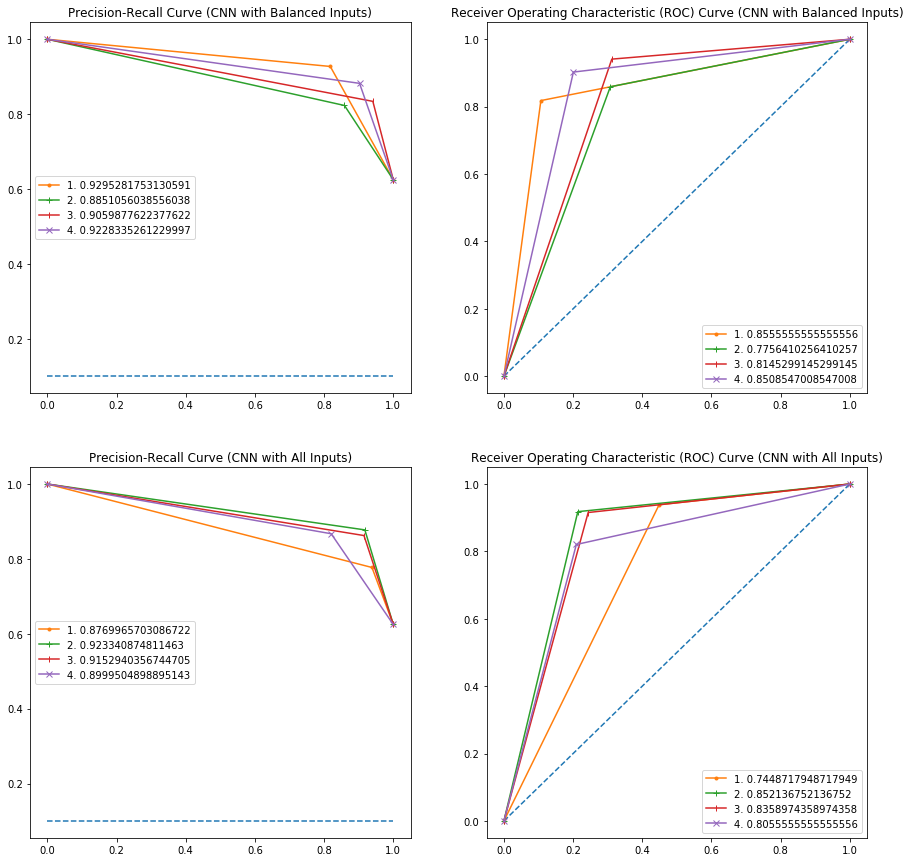

In [57]:
%matplotlib inline

fig_1 = plt.figure(figsize=(15,15))
gs_1 = gridspec.GridSpec(2, 2)


ax1 = plt.subplot(gs_1[0, 0])
# plot no skill
ax1 = plt.title('Precision-Recall Curve (CNN with Balanced Inputs)')
ax1 = plt.plot([0, 1], [0.1, 0.1], linestyle='--')
# plot the precision-recall curve for the model
ax1 = plt.plot(report_bal_1['PRC_recall'], report_bal_1['PRC_precision'], marker='.', label='1. '+str(report_bal_1['AUC']))
ax1 = plt.plot(report_bal_2['PRC_recall'], report_bal_2['PRC_precision'], marker='+', label='2. '+str(report_bal_2['AUC']))
ax1 = plt.plot(report_bal_3['PRC_recall'], report_bal_3['PRC_precision'], marker='|', label='3. '+str(report_bal_3['AUC']))
ax1 = plt.plot(report_bal_4['PRC_recall'], report_bal_4['PRC_precision'], marker='x', label='4. '+str(report_bal_4['AUC']))
plt.legend()
# show the plot


ax2 = plt.subplot(gs_1[0, 1])
ax2 = plt.title('Receiver Operating Characteristic (ROC) Curve (CNN with Balanced Inputs)')
# plot no skill
ax2 = plt.plot([0, 1], [0, 1], linestyle='--')
# plot the precision-recall curve for the model
ax2 = plt.plot(report_bal_1['fpr'], report_bal_1['tpr'], marker='.', label='1. '+str(report_bal_1['ROC_AUC']))
ax2 = plt.plot(report_bal_2['fpr'], report_bal_2['tpr'], marker='+', label='2. '+str(report_bal_2['ROC_AUC']))
ax2 = plt.plot(report_bal_3['fpr'], report_bal_3['tpr'], marker='|', label='3. '+str(report_bal_3['ROC_AUC']))
ax2 = plt.plot(report_bal_4['fpr'], report_bal_4['tpr'], marker='x', label='4. '+str(report_bal_4['ROC_AUC']))
plt.legend()
# show the plot

ax3 = plt.subplot(gs_1[1, 0])
# plot no skill
ax3 = plt.title('Precision-Recall Curve (CNN with All Inputs)')
ax3 = plt.plot([0, 1], [0.1, 0.1], linestyle='--')
# plot the precision-recall curve for the model
ax3 = plt.plot(report_unbal_1['PRC_recall'], report_unbal_1['PRC_precision'], marker='.', label='1. '+str(report_unbal_1['AUC']))
ax3 = plt.plot(report_unbal_2['PRC_recall'], report_unbal_2['PRC_precision'], marker='+', label='2. '+str(report_unbal_2['AUC']))
ax3 = plt.plot(report_unbal_3['PRC_recall'], report_unbal_3['PRC_precision'], marker='|', label='3. '+str(report_unbal_3['AUC']))
ax3 = plt.plot(report_unbal_4['PRC_recall'], report_unbal_4['PRC_precision'], marker='x', label='4. '+str(report_unbal_4['AUC']))
plt.legend()
# show the plot


ax4 = plt.subplot(gs_1[1, 1])
ax4 = plt.title('Receiver Operating Characteristic (ROC) Curve (CNN with All Inputs)')
# plot no skill
ax4 = plt.plot([0, 1], [0, 1], linestyle='--')
# plot the precision-recall curve for the model
ax4 = plt.plot(report_unbal_1['fpr'], report_unbal_1['tpr'], marker='.', label='1. '+str(report_unbal_1['ROC_AUC']))
ax4 = plt.plot(report_unbal_2['fpr'], report_unbal_2['tpr'], marker='+', label='2. '+str(report_unbal_2['ROC_AUC']))
ax4 = plt.plot(report_unbal_3['fpr'], report_unbal_3['tpr'], marker='|', label='3. '+str(report_unbal_3['ROC_AUC']))
ax4 = plt.plot(report_unbal_4['fpr'], report_unbal_4['tpr'], marker='x', label='4. '+str(report_unbal_4['ROC_AUC']))
plt.legend()
# show the plot


plt.show()

In [0]:
report_metrics(cnn_model1,test_tensors,test_targets)['PRC_precision']

array([0.625     , 0.76808511, 1.        ])

In [60]:
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
#Load the Inception_V3 model
inception_model = inception_v3.InceptionV3(weights='imagenet')
 
  



{'acc': [0.9463087248766626,
  0.9601044001461942,
  0.9574944076477637,
  0.958985831913532,
  0.9634601048441808,
  0.9630872488110747,
  0.9668158095866153,
  0.9645786722323327,
  0.9656972404649949,
  0.9597315432241299,
  0.964205816999289,
  0.9683072330078734,
  0.9664429534646133],
 'loss': [0.15096463458605616,
  0.11666792011656572,
  0.11174879529243259,
  0.10667020894759276,
  0.10014787666071803,
  0.10284374144253315,
  0.08799024345179621,
  0.1021767524664834,
  0.09876664877382345,
  0.10255423135427642,
  0.09860858179512173,
  0.08979393516255349,
  0.08931342895732364],
 'val_acc': [0.6875,
  0.5,
  0.8125,
  0.8125,
  0.5,
  0.8125,
  0.5,
  0.6875,
  0.5,
  0.875,
  0.5625,
  0.5625,
  0.6875],
 'val_loss': [0.8976752161979675,
  0.8179812431335449,
  0.2765098810195923,
  0.31466275453567505,
  5.2873992919921875,
  0.6651317477226257,
  1.317141056060791,
  0.9099451899528503,
  2.8215246200561523,
  0.3676450848579407,
  3.4156203269958496,
  2.95526218414306

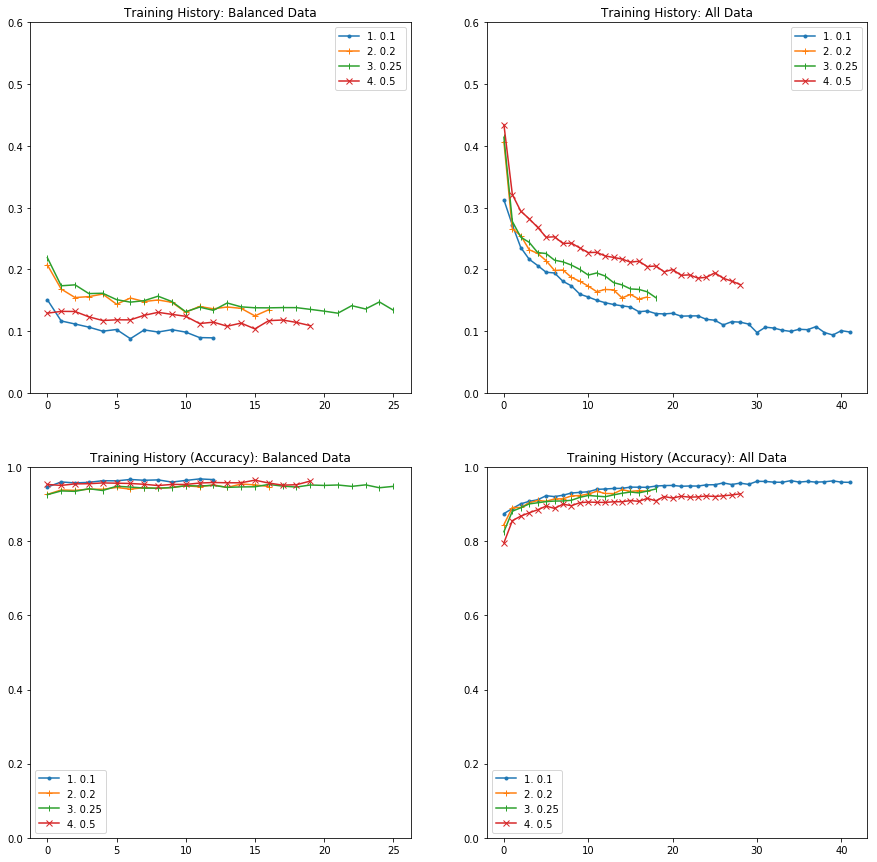

In [62]:
%matplotlib inline

fig_2 = plt.figure(figsize=(15,15))
gs_2 = gridspec.GridSpec(2, 2)


ax1 = plt.subplot(gs_2[0, 0])
ax1 = plt.title('Training History: Balanced Data')
ax1 = plt.plot(train_bal_cnn1.history['loss'], marker='.', label='1. 0.1')
ax1 = plt.plot(train_bal_cnn2.history['loss'], marker='+', label='2. 0.2')
ax1 = plt.plot(train_bal_cnn3.history['loss'], marker='|', label='3. 0.25')
ax1 = plt.plot(train_bal_cnn4.history['loss'], marker='x', label='4. 0.5')
ax1 = plt.ylim([0,0.6])
plt.legend()
# show the plot


ax2 = plt.subplot(gs_2[0, 1])
ax2 = plt.title('Training History: All Data')
ax2 = plt.plot(train_unbal_cnn1.history['loss'], marker='.', label='1. 0.1')
ax2 = plt.plot(train_unbal_cnn2.history['loss'], marker='+', label='2. 0.2')
ax2 = plt.plot(train_unbal_cnn3.history['loss'], marker='|', label='3. 0.25')
ax2 = plt.plot(train_unbal_cnn4.history['loss'], marker='x', label='4. 0.5')
ax2 = plt.ylim([0,0.6])
plt.legend()
# show the plot



ax3 = plt.subplot(gs_2[1, 0])
ax3 = plt.title('Training History (Accuracy): Balanced Data')
ax3 = plt.plot(train_bal_cnn1.history['acc'], marker='.', label='1. 0.1')
ax3 = plt.plot(train_bal_cnn2.history['acc'], marker='+', label='2. 0.2')
ax3 = plt.plot(train_bal_cnn3.history['acc'], marker='|', label='3. 0.25')
ax3 = plt.plot(train_bal_cnn4.history['acc'], marker='x', label='4. 0.5')
ax3 = plt.ylim([0,1])
plt.legend()
# show the plot


ax4 = plt.subplot(gs_2[1, 1])
ax4 = plt.title('Training History (Accuracy): All Data')
ax4 = plt.plot(train_unbal_cnn1.history['acc'], marker='.', label='1. 0.1')
ax4 = plt.plot(train_unbal_cnn2.history['acc'], marker='+', label='2. 0.2')
ax4 = plt.plot(train_unbal_cnn3.history['acc'], marker='|', label='3. 0.25')
ax4 = plt.plot(train_unbal_cnn4.history['acc'], marker='x', label='4. 0.5')
ax4 = plt.ylim([0,1])
plt.legend()
# show the plot
plt.show()

In [63]:
!ls -a

.  ..  saved_models  test  train  val


In [64]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [90]:
cd /content/chest_xray/saved_models

/content/chest_xray/saved_models


In [83]:
cd /content/gdrive/My Drive/Colab_stuff

/content/gdrive/My Drive/Colab_stuff


In [92]:
!ls -la

total 15656
drwxr-xr-x 2 root root    4096 May 22 15:27 .
drwxr-xr-x 6 root root    4096 May 22 13:01 ..
-rw-r--r-- 1 root root 1999688 May 22 14:58 best_cnn1_bal.hdf5
-rw-r--r-- 1 root root 1999688 May 22 13:36 best_cnn1_unbal.hdf5
-rw-r--r-- 1 root root 2000056 May 22 15:08 best_cnn2_bal.hdf5
-rw-r--r-- 1 root root 2000056 May 22 13:55 best_cnn2_unbal.hdf5
-rw-r--r-- 1 root root 1999696 May 22 15:22 best_cnn3_bal.hdf5
-rw-r--r-- 1 root root 1999696 May 22 14:15 best_cnn3_unbal.hdf5
-rw-r--r-- 1 root root 1999696 May 22 15:32 best_cnn4_bal.hdf5
-rw-r--r-- 1 root root 1999696 May 22 14:46 best_cnn4_unbal.hdf5


In [0]:
!cp /content/chest_xray/saved_models/* '/content/gdrive/My Drive/Colab_stuff/saved_models/'

In [0]:
!mkdir saved_models